In [1]:
#Generic Python packages
import gc
import os
import numpy as np
import pandas as pd
#opening and dealing with files
import fitsio
#Coordinate systems
import astropy.units as u
from astropy.coordinates import SkyCoord
import healpy as hp
from astropy.wcs import WCS
#Big Beautiful Plots
import pylab as plt

# LSST Science Pipelines (Stack) Packages
from lsst.rsp import get_tap_service, retrieve_query

my_path =  '/sdf/data/rubin/user/kexcel/plots'

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

### STEP 1: load catalogs into memory for a region
- ~~things / syntax might change w LSSTcam/DP1 but at any rate want obj table~~
    - ~~will have deep coadd stars and gals. summary table (vs the special astropy tables)~~
    - ~~in his rehearsal scripts what was prev called object table tract is maybe now called object all~~
    - ~~apparently they "changed everything" might change again for dp1~~
- ~~be able to load into memory the dp1 object table and the euc deep field south and ecdfs field~~
- what are the columns that we need (see paper and maybe specifically star galaxy separation) 
- ~~validation: plot a small small region RA and DEC for both catalogs and see that they match~~
- columns: COMCAM relevant filters to point source and extended source photometry (two diff models), EUC vis + ghy
    - flags to select quality objects and something for star galaxy sep

### STEP 1.5: S-G sep plot
- ~~how to check phot is reasonable, for each cat individ being able to create a star-gal sep plot~~
    - (peak surface brightness - total flux vs mag. stars will converge to 0 while gal is like a negative slope)

### STEP 2: merge catalogs spatially
-  ~~simplest is w astropy coords~~

#### Q: How do you decide which collection for butler? -> there'd be a dp1 collection
#### Q: is TAP the best way? -> it's recommended I suppose. note! the flags seem to need to be applied as constraints on the query instead of columns like in the butler

In [2]:
service = get_tap_service("tap")
assert service is not None

In [3]:
def querylsst(service, query_cuts, ra, dec, radius=1.0):
    #from Kabelo Tsaine's simple_adl/query_TAP.py
    #edited so it works on dp1 syntax
    """ Return data queried from Rubin TAP
    
    Parameters
    ----------
    service: str 
        TAP service
    ra: float
        Right Ascension [deg]
    dec: float 
        Declination [deg]
    radius: float
        Radius around (ra, dec) [deg]

    Returns
    -------
    good_results: DataFrame
    """

    coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    radius = radius * u.deg   
   
    query = f"""
        SELECT
            coord_ra AS ra, coord_dec AS dec,
            g_extendedness, r_extendedness, i_extendedness, z_extendedness, 
            g_SizeExtendedness, r_SizeExtendedness, i_SizeExtendedness, z_SizeExtendedness,
            g_psfFlux, r_psfFlux, i_psfFlux, z_psfFlux,
            g_psfFluxErr, r_psfFluxErr, i_psfFluxErr, z_psfFluxErr,
            g_cModelFlux, r_cModelFlux, i_cModelFlux, z_cModelFlux
        FROM dp1.Object
        WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), CIRCLE('ICRS', {coord.ra.value}, {coord.dec.value}, {radius.value})) = 1
        """ + query_cuts
    
    job = service.submit_job(query)
    job.run()
    job.wait(phases=['COMPLETED', 'ERROR'])
    async_results = job.fetch_result()
    results = async_results.to_table().to_pandas()
    job.delete()
    
    return results

In [4]:
#this hasn't been cleaned up much / at all
query_cuts = ""
safe_max_extended = 1.0
query_cuts += f"AND g_extendedness <= {str(safe_max_extended)} "
query_cuts +=  "AND detect_isIsolated = 1"
for band in 'griz':
    query_cuts += f"AND {band}_psfFlux_flag = 0"
field = "EDFS"
cuts = "all"
lsst_query = querylsst(service, query_cuts, 59.10, -48.73, radius=2.0)
lsst_mask = (lsst_query['r_psfFlux'] / lsst_query['r_psfFluxErr']) > 5
lsst_field = lsst_query[lsst_mask]

lsst_field.sort_values('dec')

,ra,dec,g_extendedness,r_extendedness,i_extendedness,z_extendedness,g_SizeExtendedness,r_SizeExtendedness,i_SizeExtendedness,z_SizeExtendedness,...,i_psfFlux,z_psfFlux,g_psfFluxErr,r_psfFluxErr,i_psfFluxErr,z_psfFluxErr,g_cModelFlux,r_cModelFlux,i_cModelFlux,z_cModelFlux
998,59.072768,-49.364450,1.0,1.0,0.0,0.0,NaN,0.979722,0.005305,0.642564,...,1754.079956,2644.620117,86.500298,153.403000,204.179001,395.342010,323.868011,1053.750000,1772.140015,2679.459961
999,59.098677,-49.361943,1.0,0.0,1.0,0.0,0.496271,0.116834,0.208882,0.053155,...,3563.699951,5042.100098,84.077698,115.380997,208.358994,394.441986,767.674011,2022.869995,3929.600098,5364.060059
1000,59.070619,-49.358459,1.0,1.0,1.0,1.0,0.996076,0.417470,0.928791,0.994298,...,1888.500000,2715.850098,83.999603,95.187103,200.940994,391.808990,964.591980,1383.079956,2780.679932,3284.550049
1001,59.100317,-49.353050,1.0,0.0,1.0,0.0,0.595646,0.048479,0.003886,0.000942,...,10764.900391,22445.099609,83.710602,97.152000,218.559998,312.407013,785.158020,2531.600098,11011.000000,22785.599609
1002,59.071239,-49.351541,0.0,1.0,1.0,NaN,0.063553,0.115296,NaN,NaN,...,1272.000000,2651.780029,85.169197,95.795197,197.692993,332.028992,1166.280029,1531.670044,1394.810059,2784.209961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,59.222819,-48.163222,1.0,0.0,1.0,1.0,0.768846,0.124611,0.948882,0.072178,...,5515.799805,6694.009766,59.663200,342.519012,368.739014,502.213013,1968.670044,4252.810059,7406.799805,9650.519531
55,59.219100,-48.157704,1.0,1.0,1.0,1.0,0.921472,0.390466,0.628840,0.986863,...,7385.089844,8807.519531,61.056400,345.213013,372.438995,505.446014,2427.699951,5727.899902,8557.500000,10374.099609
54,59.193354,-48.155668,0.0,NaN,1.0,0.0,0.001292,NaN,0.033895,0.001359,...,18533.000000,32536.000000,60.390301,347.278992,380.188995,341.916992,1632.170044,4804.799805,19054.000000,33573.800781
53,59.233313,-48.154722,1.0,1.0,1.0,0.0,0.041446,0.674289,0.022723,0.179314,...,4395.359863,5044.149902,83.985397,335.998993,373.182007,503.377014,1801.449951,3138.550049,4538.129883,5020.609863


Peter gave this path for all Euclid q1 catalogs and the images (Y, J, H, and VIS) part of Euclid Deep Field South: '/sdf/group/rubin/shared/euclid/'

Dan Taranu gave this path for ECDFS Euclid VIS/NISP imaging: '/sdf/data/rubin/user/dtaranu/tickets/cdfs/euclid/'

In [5]:
#coarser resolution to load in euclid files, which follow nside = 64 pixel name convention
nside = 64
lsst_ra = lsst_field['ra']
lsst_dec = lsst_field['dec']
lsst_pix64 = hp.ang2pix(nside, lsst_ra, lsst_dec, lonlat=True, nest=True)
lsst_upix64 = np.unique(lsst_pix64.values)

#%cd /sdf/group/rubin/shared/euclid/q1/catalogs

euclid_path = "/sdf/group/rubin/shared/euclid/q1/catalogs/"
euclid = []
for pix in lsst_upix64:
    euclid.append(fitsio.read(euclid_path + f"euclid_q1_mer_final_{pix:05d}.fits"))
euclid_fits = np.concatenate(euclid)
print(len(euclid), len(euclid_fits))

5 1865902


#### Q: Does fitsio automatically close after reading?

Flags, explained in 'Euclid Quick Data Release (Q1), The active galaxies of Euclid' by Matamoro Zatarain et al. 2025:  
- "DET_QUALITY_FLAG values of 0, 2, and 512 indicate no problems with the data, sources blended together, 
and sources within an extended object area, respectively."
- <band>_FLAG = detect contamination in specific bands
- SPURIOUS_FLAG = detect contamination by spurious sources

In [6]:
#now get greater resolution to match up
NSIDE=4096
lsst_upix4096, lsst_cts = np.unique(hp.ang2pix(NSIDE, lsst_ra, lsst_dec, lonlat=True), return_counts=True)
euclid_pix4096 = hp.ang2pix(NSIDE, euclid_fits['RIGHT_ASCENSION'], euclid_fits['DECLINATION'], lonlat=True)
mask = np.isin(euclid_pix4096, lsst_upix4096) #[comcam_cts > 8])
print(len(euclid_pix4096), euclid_pix4096)
print(len(lsst_upix4096), lsst_upix4096)

mask &= (euclid_fits['FLUX_VIS_PSF'] / euclid_fits['FLUXERR_VIS_PSF'] > 5)  #<-- clever syntax from Peter
mask &= (euclid_fits['SPURIOUS_FLAG'] == 0)
mask &= ((euclid_fits['DET_QUALITY_FLAG'] == 0) | (euclid_fits['DET_QUALITY_FLAG'] == 2) | (euclid_fits['DET_QUALITY_FLAG'] == 512))
for band in ['VIS', 'Y', 'J', 'H']:
    mask &= (euclid_fits[f'FLAG_{band}'] == 0)

euclid_field = euclid_fits[mask]
euclid_ra = euclid_field['RIGHT_ASCENSION']
euclid_dec = euclid_field['DECLINATION']



1865902 [177475567 177475564 177489379 ... 175257502 175257502 175257502]
4439 [175646004 175646005 175646006 ... 177045398 177045399 177045400]


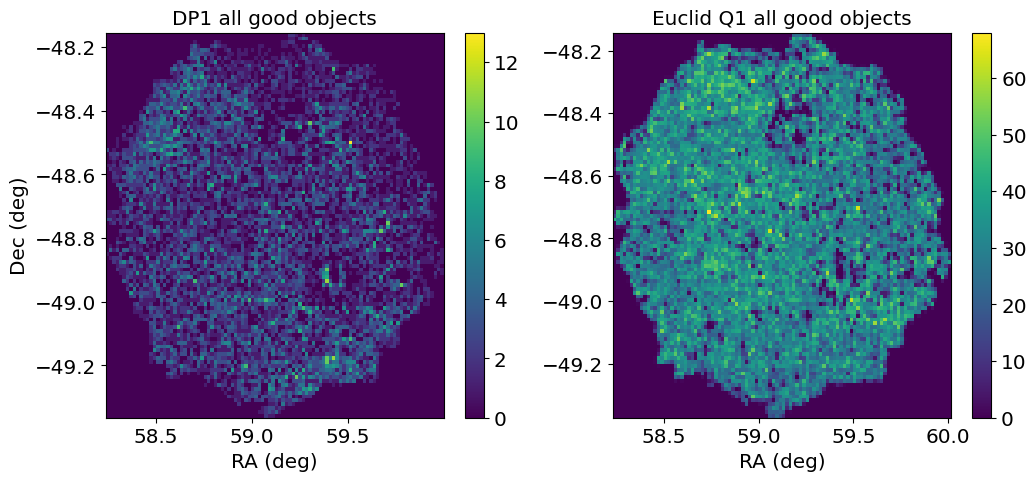

In [7]:
##Coordinate verification
##this entire cell is pulled from Peter's notebook

fig, ax = plt.subplots(1,2, figsize=(12,5))

_, _, _, im = ax[0].hist2d(lsst_ra, lsst_dec, bins=100)
plt.colorbar(im, ax=ax[0])
ax[0].set_title('DP1 all good objects')
ax[0].set_ylabel("Dec (deg)")
ax[0].set_xlabel("RA (deg)")

_, _, _, im = ax[1].hist2d(euclid_ra, euclid_dec, bins=100)
plt.colorbar(im, ax=ax[1])
ax[1].set_title("Euclid Q1 all good objects")
ax[1].set_xlabel("RA (deg)")
plt.savefig(my_path + f"/DP1_EUCLID_{field}maps_{cuts}mask.png")

#### Q: what are those artifacts? some sort of detector or pipeline (detector -> catalog) issue I suppose

Notes to self:
- artifacts present in plot with no mask, so is it a detector issue...?
    - comcam gets up to >100 sources in pixel w no mask
- even more splotchyness/artifacts when just a g_extendedness < 1 mask applied (what does that mask cut out?)
    - comcam cut down severely, get only to 50 sources in pixel
- detect_isIsolated big cut, takes it down to only max ~18 sources
- band flag mask only do a small cut (max ~16) and the SNR based on r band is a smaller cut too (max ~12)
- Euclid's SNR mask (at least, that mask being applied first) cuts it from 140 -> 80
- applying "euclid_fits['DET_QUALITY_FLAG'] == 0" gets this weird square in Euclid
    - oops! changing it to "(euclid_fits['DET_QUALITY_FLAG'] == 0) | (euclid_fits['DET_QUALITY_FLAG'] == 2) | (euclid_fits['DET_QUALITY_FLAG'] == 512)" fixes that

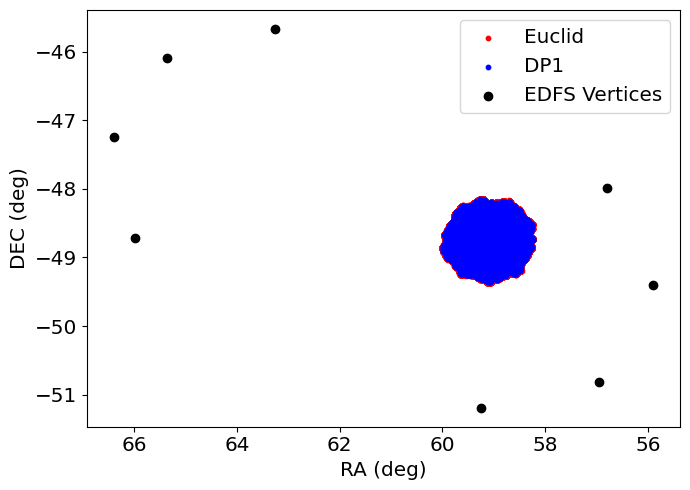

In [25]:
##Another coordinate verification
fig, ax = plt.subplots(1,1, figsize=(7,5))

#Define EDFS polygon region (vertices from Euclid)
vertices = np.array([[63.25, -45.67], [65.35, -46.10], [66.40, -47.25], 
       [65.99, -48.72], [59.25, -51.19], [56.95, -50.82], 
       [55.90, -49.40], [56.80, -47.99]])

ax.scatter(euclid_ra, euclid_dec, s = 10, color='red', label = "Euclid")
ax.scatter(lsst_ra, lsst_dec, s = 10, color = 'blue', label = "DP1")
ax.set(xlabel = "RA (deg)", ylabel = "DEC (deg)")
ax.invert_xaxis()
euclid_center =  SkyCoord('04:04:57.84 -48:25:22.8', unit=(u.hourangle, u.deg), frame = 'icrs')
lsst_center = SkyCoord('59.10 -48.73', unit=(u.deg, u.deg), frame = 'icrs')
#plt.scatter(comcam_center.ra.deg, comcam_center.dec.deg, color = 'red', marker = '*', label = 'ComCam Center')
#plt.scatter(euclid_center.ra.deg, euclid_center.dec.deg, color = 'red', marker = '*', label = 'Euclid Center')
plt.scatter(vertices[:, 0], vertices[:, 1], color = 'k', label = 'EDFS Vertices')
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.savefig(my_path + '/context_of_field')

note to self: it looks like the pixel matching is working well to not include euclid sources where comcam has blank artifacts. still don't know what those artifacts are

4081 5256


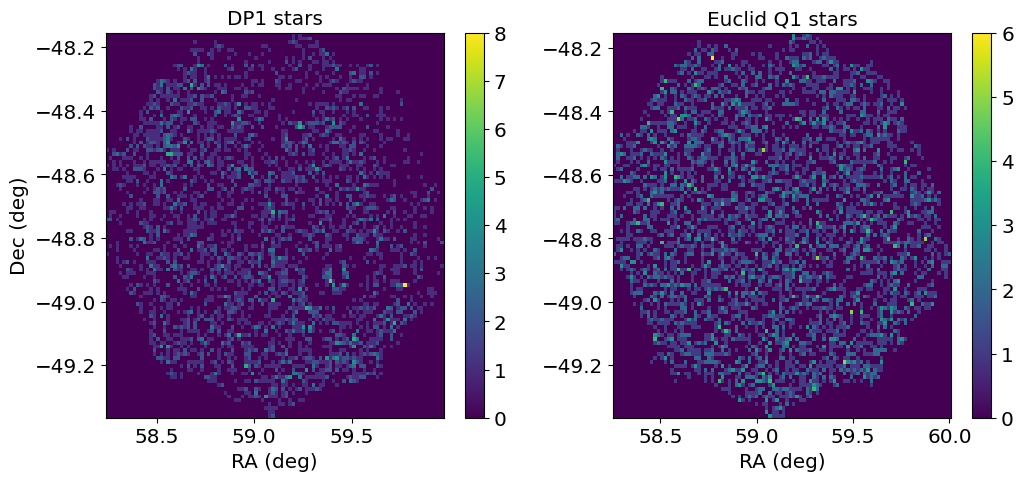

In [9]:
euclid_stars = euclid_field[euclid_field['POINT_LIKE_PROB'] > 0.7]
euclid_stars_ra = euclid_stars['RIGHT_ASCENSION']
euclid_stars_dec = euclid_stars['DECLINATION']
#one possible criterion
stardef = 'i_SizeExtendedness'
lsst_stars = lsst_field[lsst_field['i_SizeExtendedness'] < 0.5]
#another possible criteria
#stardef = 'randgextendedness'
#comcam_stars = comcam_field[(comcam_field['r_extendedness'] < 0.5) & (comcam_field['g_extendedness'] < 0.5)]
lsst_stars_ra = lsst_stars['ra']
lsst_stars_dec = lsst_stars['dec']

fig, ax = plt.subplots(1,2, figsize=(12,5))

_, _, _, im = ax[0].hist2d(lsst_stars_ra, lsst_stars_dec, bins=100)
plt.colorbar(im, ax=ax[0])
ax[0].set_title('DP1 stars')
ax[0].set_ylabel("Dec (deg)")
ax[0].set_xlabel("RA (deg)")

_, _, _, im = ax[1].hist2d(euclid_stars_ra, euclid_stars_dec, bins=100)
plt.colorbar(im, ax=ax[1])
ax[1].set_title("Euclid Q1 stars")
ax[1].set_xlabel("RA (deg)")
plt.savefig(my_path + f"/stars_DP1_EUCLID_{field}maps_basedon{stardef}.png")

print(len(lsst_stars), len(euclid_stars))

#### Q: what's zeropoint determined from? -> Rubin measures in nJy. AB system wants 0 mag to be ~ 3631 Jy which is $3.631 \times 10^{12} \rm{nJy}$ $$\\m = -2.5\log_{10}(f_v) + 2.5log_{10}(3.631 \times 10^{12}) = -2.5\log_{10}(f_v) + 31.4$$

#### Q: where can I read the theory/reasoning behind why these plots?
#### Q: what's cmodel/physical meaning of psf - cmodel?

/tmp/ipykernel_3119/1497302383.py:4: RuntimeWarning: invalid value encountered in log10
  return -2.5*np.log10(flux) + zeropoint


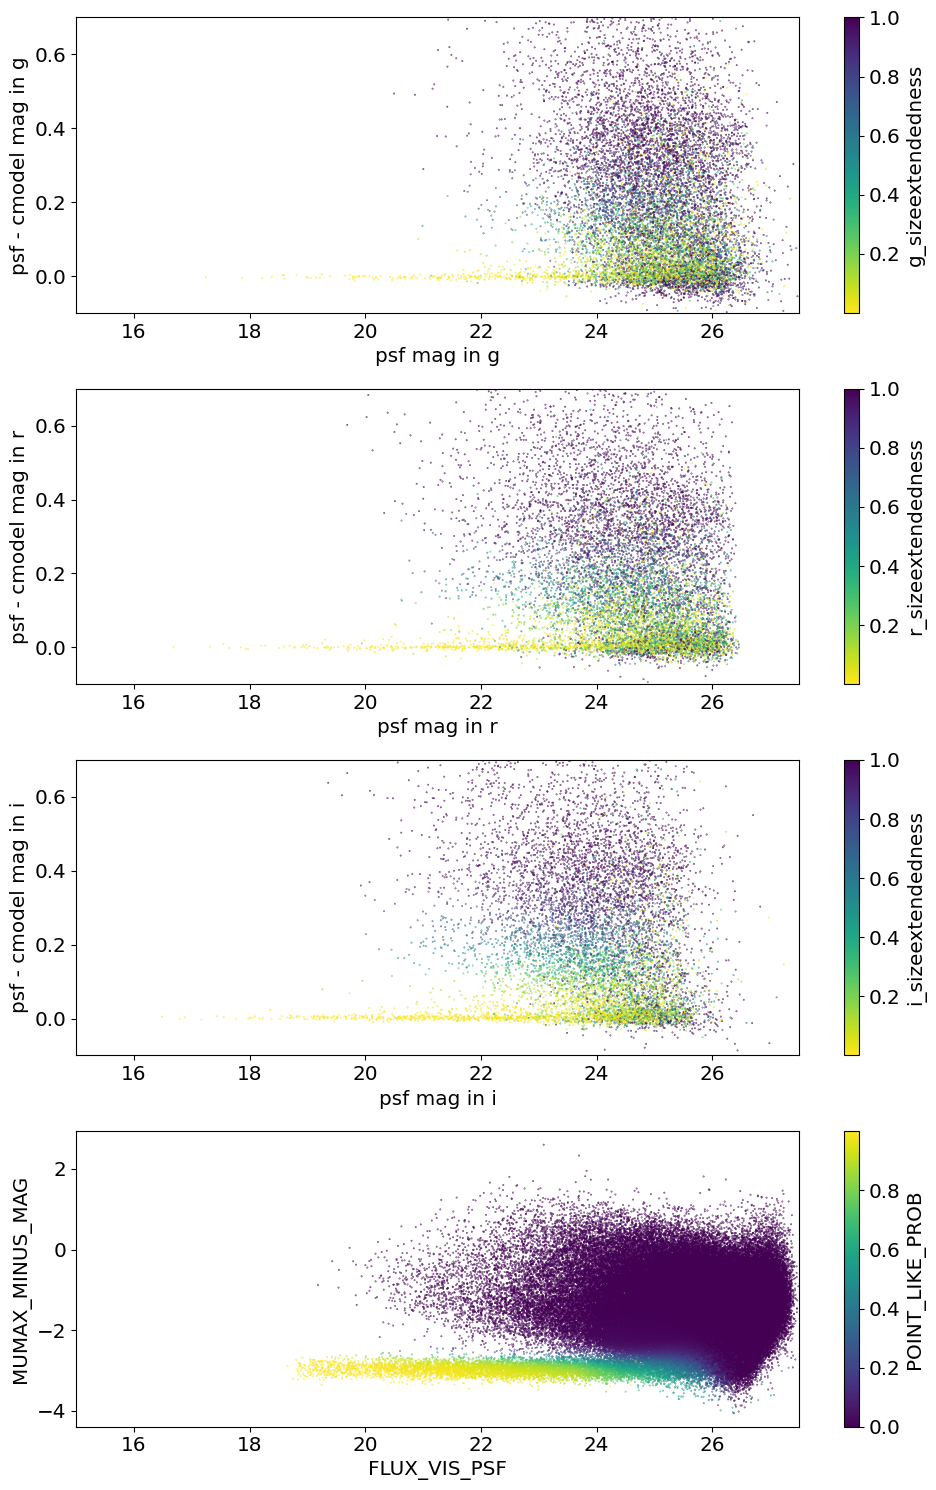

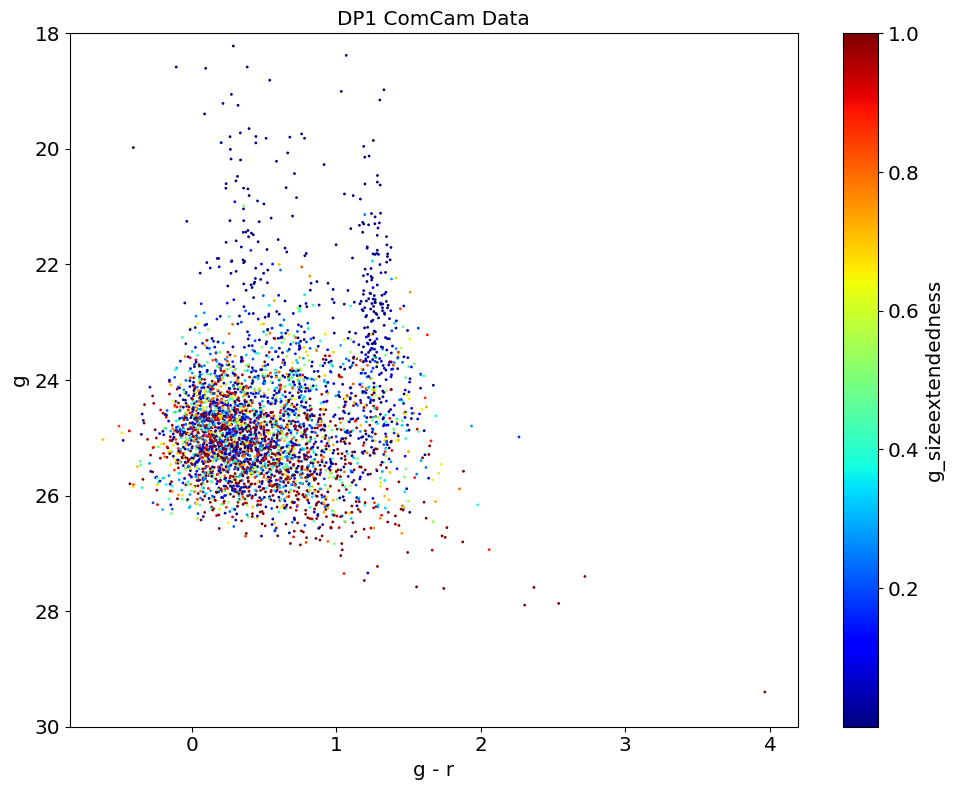

In [10]:
#again, pulled from Peter
zeropoint = 31.4 # AB zeropoint
def flux2mag(flux):
    return -2.5*np.log10(flux) + zeropoint

# color1 = mag - flux2mag(comcam["r_psfFlux"][comcam_stars].values)
# color2 = flux2mag(comcam["r_psfFlux"][comcam_stars].values) - flux2mag(comcam["i_psfFlux"][comcam_stars].values)
vis_mag = (euclid_field["FLUX_VIS_PSF"] * u.uJy).to(u.ABmag)

#plot 1 - based on i 
lsst_i_mag = flux2mag(lsst_field["i_psfFlux"].values)
lsst_i_mag_cmodel = flux2mag(lsst_field["i_cModelFlux"].values)
lsst_g_mag = flux2mag(lsst_field["g_psfFlux"].values)
lsst_g_mag_cmodel = flux2mag(lsst_field["g_cModelFlux"].values)
lsst_r_mag = flux2mag(lsst_field["r_psfFlux"].values)
lsst_r_mag_cmodel = flux2mag(lsst_field["r_cModelFlux"].values)

fig, ax = plt.subplots(4,1, figsize=(10,15))

_=ax[0].scatter(lsst_g_mag,
            lsst_g_mag - lsst_g_mag_cmodel,
            c=lsst_field["g_SizeExtendedness"],
            s=0.1, cmap="viridis_r")
plt.colorbar(_,label="g_SizeExtendedness".lower())
ax[0].set(xlabel='psf mag in g', ylabel='psf - cmodel mag in g'.lower(), 
          ylim=(-0.1,0.7), xlim=(15,27.5))

_=ax[1].scatter(lsst_r_mag,
            lsst_r_mag - lsst_r_mag_cmodel,
            c=lsst_field["r_SizeExtendedness"],
            s=0.1, cmap="viridis_r")
plt.colorbar(_,label="r_SizeExtendedness".lower())
ax[1].set(xlabel='psf mag in r', ylabel='psf - cmodel mag in r'.lower(), 
          ylim=(-0.1,0.7), xlim=(15,27.5))

_=ax[2].scatter(lsst_i_mag,
            lsst_i_mag - lsst_i_mag_cmodel,
            c=lsst_field["i_SizeExtendedness"],
            s=0.1, cmap="viridis_r")
plt.colorbar(_,label="i_SizeExtendedness".lower())
ax[2].set(xlabel='psf mag in i', ylabel='psf - cmodel mag in i'.lower(), 
          ylim=(-0.1,0.7), xlim=(15,27.5))

_=ax[3].scatter(vis_mag,
            euclid_field['MUMAX_MINUS_MAG'],
            c=euclid_field["POINT_LIKE_PROB"],
            s=0.1)
plt.colorbar(_,label="POINT_LIKE_PROB")
ax[3].set(xlabel='FLUX_VIS_PSF', 
          ylabel='MUMAX_MINUS_MAG',
          xlim=(15,27.5))
#plt.yscale('log')
plt.tight_layout()
plt.savefig(my_path + f"/photometry_attempt.png")

plt.show()

#plot 2 - based on g
fig, ax = plt.subplots(1,1, figsize=(10,8))

lsst_g_mag = flux2mag(lsst_stars["g_psfFlux"].values)
lsst_r_mag = flux2mag(lsst_stars["r_psfFlux"].values)
#comcamgi_mag_cmodel = flux2mag(comcam_field["g_cModelFlux"].values)

_=ax.scatter(lsst_g_mag - lsst_r_mag,
            lsst_g_mag,
            c=lsst_stars["g_SizeExtendedness"],
            s=1, cmap="jet")
plt.colorbar(_,label="g_SizeExtendedness".lower())
ax.set(xlabel='g - r', ylabel='g'.lower(), 
          ylim = (30, 18), title='DP1 ComCam Data')
plt.tight_layout()
plt.savefig(my_path + f"/g_v_gminr.png")


#_=ax[1].scatter(vis_mag,
#            euclid_field['MUMAX_MINUS_MAG'],
#            c=euclid_field["POINT_LIKE_PROB"],
#            s=0.1)
#plt.colorbar(_,label="POINT_LIKE_PROB".lower())
#ax[1].set(xlabel='Euclid PSF $I_E$ (vis mag)', 
#          ylabel='MUMAX_MINUS_MAG'.lower(),
#          xlim=(15,27.5))

According to SDSS at least:  
cmodel = "Composite model magnitude. The magnitude obtained from the best-fitting linear combination of the best-fitting de Vaucouleurs and exponential model for an object's light profile"  
psf = "For isolated stars, which are well-described by the point spread function (PSF), the optimal measure of the total flux is determined by fitting a PSF model to the object."  
for stars these should be about the same

Notes to self:
- first, I seem to have a great number less of sources than Peter in his comcam plot. I don't think we have different cuts at all, except the g_extendedness < 1.0
- I can see the gradation of i_SizeExtendedness vs i_extendness (just 1 or 0)

#### Q: I was going to compare ugali and astropy, but I can't seem to install/import ugali (pip isn't working)

From astropy matching documentation: "d3d are 3-dimensional distances. Unless both source (c) and catalog (catalog) coordinates have associated distances, this quantity assumes that all sources are at a distance of 1 (dimensionless).""

**soooooooooooo something's going on. gotta figure out what astropy's algorithm does. those aren't even close to being the same.
How to create just matches that are 1 arcsec apart:**  
*max_sep = 1.0 * u.arcsec  
idx, d2d, d3d = c.match_to_catalog_3d(catalog)  
sep_constraint = d2d < max_sep  
c_matches = c[sep_constraint]  
catalog_matches = catalog[idx[sep_constraint]]*

In [11]:
class SphericalRotator:
    """
    Base class for rotating points on a sphere.

    The input is a fiducial point (deg) which becomes (0, 0) in rotated coordinates.
    """

    def __init__(self, lon_ref, lat_ref, zenithal=False):
        self.setReference(lon_ref, lat_ref, zenithal)

    def setReference(self, lon_ref, lat_ref, zenithal=False):

        if zenithal:
            phi = (np.pi / 2.) + np.radians(lon_ref)
            theta = (np.pi / 2.) - np.radians(lat_ref)
            psi = 0.
        if not zenithal:
            phi = (-np.pi / 2.) + np.radians(lon_ref)
            theta = np.radians(lat_ref)
            # psi = 90 corresponds to (0, 0)
            # psi = -90 corresponds to (180, 0)
            psi = np.radians(90.)

        cos_psi,sin_psi = np.cos(psi),np.sin(psi)
        cos_phi,sin_phi = np.cos(phi),np.sin(phi)
        cos_theta,sin_theta = np.cos(theta),np.sin(theta)

        self.rotation_matrix = np.array([
            [cos_psi * cos_phi - cos_theta * sin_phi * sin_psi,
             cos_psi * sin_phi + cos_theta * cos_phi * sin_psi,
             sin_psi * sin_theta],
            [-sin_psi * cos_phi - cos_theta * sin_phi * cos_psi,
             -sin_psi * sin_phi + cos_theta * cos_phi * cos_psi,
             cos_psi * sin_theta],
            [sin_theta * sin_phi,
             -sin_theta * cos_phi,
             cos_theta]
        ])
        
        self.inverted_rotation_matrix = np.linalg.inv(self.rotation_matrix)

    def cartesian(self,lon,lat):
        lon = np.radians(lon)
        lat = np.radians(lat) 
        
        x = np.cos(lat) * np.cos(lon)
        y = np.cos(lat) * np.sin(lon)
        z =  np.sin(lat)
        return np.array([x,y,z])
        

    def rotate(self, lon, lat, invert=False):
        vec = self.cartesian(lon,lat)

        if invert:
            vec_prime = np.dot(np.array(self.inverted_rotation_matrix), vec)
        else:        
            vec_prime = np.dot(np.array(self.rotation_matrix), vec)

        lon_prime = np.arctan2(vec_prime[1], vec_prime[0])
        lat_prime = np.arcsin(vec_prime[2])

        return (np.degrees(lon_prime) % 360.), np.degrees(lat_prime)

def angsep(lon1,lat1,lon2,lat2):
    """
    Angular separation (deg) between two sky coordinates.
    Borrowed from astropy (www.astropy.org)

    Notes
    -----
    The angular separation is calculated using the Vincenty formula [1],
    which is slighly more complex and computationally expensive than
    some alternatives, but is stable at at all distances, including the
    poles and antipodes.

    [1] http://en.wikipedia.org/wiki/Great-circle_distance
    """
    lon1,lat1 = np.radians([lon1,lat1])
    lon2,lat2 = np.radians([lon2,lat2])
    
    sdlon = np.sin(lon2 - lon1)
    cdlon = np.cos(lon2 - lon1)
    slat1 = np.sin(lat1)
    slat2 = np.sin(lat2)
    clat1 = np.cos(lat1)
    clat2 = np.cos(lat2)

    num1 = clat2 * sdlon
    num2 = clat1 * slat2 - slat1 * clat2 * cdlon
    denominator = slat1 * slat2 + clat1 * clat2 * cdlon

    return np.degrees(np.arctan2(np.hypot(num1,num2), denominator))


10337 10337


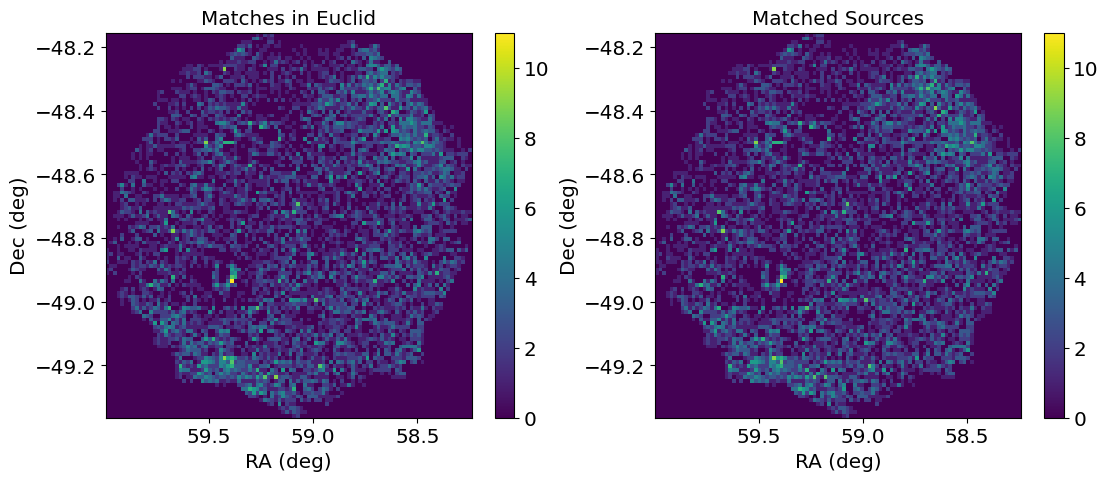

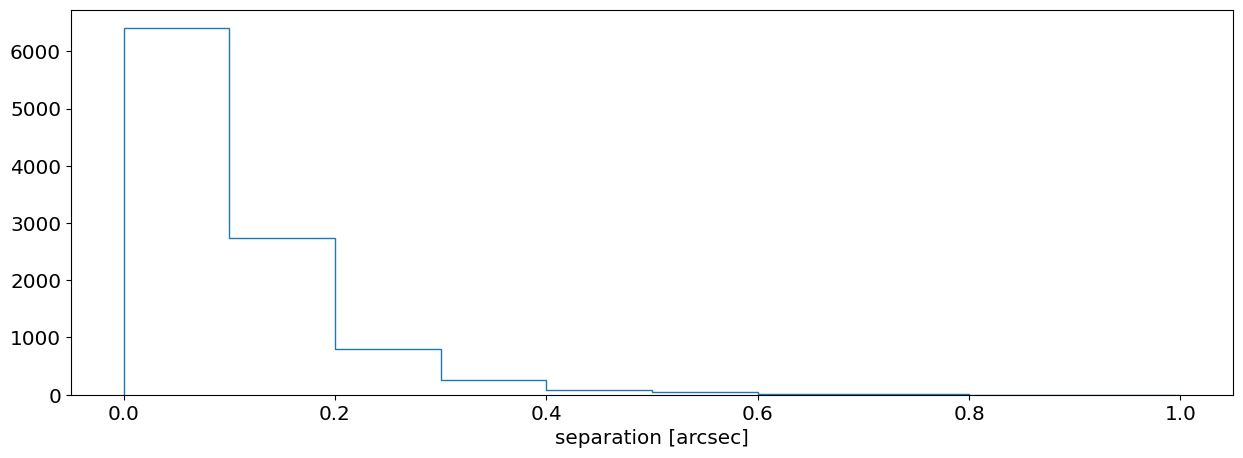

In [23]:
##copy and pasted from DES ugali because I *can't get ugali to install*
def match(lon1, lat1, lon2, lat2, tol=None, nnearest=1):
    """
    Adapted from Eric Tollerud.
    Finds matches in one catalog to another.
 
    Parameters
    lon1 : array-like
        Longitude of the first catalog (degrees)
    lat1 : array-like
        Latitude of the first catalog (shape of array must match `lon1`)
    lon2 : array-like
        Longitude of the second catalog
    lat2 : array-like
        Latitude of the second catalog (shape of array must match `lon2`)
    tol : float or None, optional
        Proximity (degrees) of a match to count as a match.  If None,
        all nearest neighbors for the first catalog will be returned.
    nnearest : int, optional
        The nth neighbor to find.  E.g., 1 for the nearest nearby, 2 for the
        second nearest neighbor, etc.  Particularly useful if you want to get
        the nearest *non-self* neighbor of a catalog.  To do this, use:
        ``spherematch(lon, lat, lon, lat, nnearest=2)``
 
    Returns
    -------
    idx1 : int array
        Indices into the first catalog of the matches. Will never be
        larger than `lon1`/`lat1`.
    idx2 : int array
        Indices into the second catalog of the matches. Will never be
        larger than `lon2`/`lat2`.
    ds : float array
        Distance (in degrees) between the matches
    """
    from scipy.spatial import cKDTree
 
    lon1 = np.asarray(lon1)
    lat1 = np.asarray(lat1)
    lon2 = np.asarray(lon2)
    lat2 = np.asarray(lat2)
 
    if lon1.shape != lat1.shape:
        raise ValueError('lon1 and lat1 do not match!')
    if lon2.shape != lat2.shape:
        raise ValueError('lon2 and lat2 do not match!')

    rotator = SphericalRotator(0,0)

 
    # This is equivalent, but faster than just doing np.array([x1, y1, z1]).T
    x1, y1, z1 = rotator.cartesian(lon1.ravel(),lat1.ravel())
    coords1 = np.empty((x1.size, 3))
    coords1[:, 0] = x1
    coords1[:, 1] = y1
    coords1[:, 2] = z1
 
    x2, y2, z2 = rotator.cartesian(lon2.ravel(),lat2.ravel())
    coords2 = np.empty((x2.size, 3))
    coords2[:, 0] = x2
    coords2[:, 1] = y2
    coords2[:, 2] = z2
 
    tree = cKDTree(coords2)
    if nnearest == 1:
        idxs2 = tree.query(coords1)[1]
    elif nnearest > 1:
        idxs2 = tree.query(coords1, nnearest)[1][:, -1]
    else:
        raise ValueError('invalid nnearest ' + str(nnearest))
 
    ds = angsep(lon1, lat1, lon2[idxs2], lat2[idxs2])
 
    idxs1 = np.arange(lon1.size)
 
    if tol is not None:
        msk = ds < tol
        idxs1 = idxs1[msk]
        idxs2 = idxs2[msk]
        ds = ds[msk]
 
    return idxs1, idxs2, ds

indexlsst, indexeuclid, ds = match(lsst_ra.values, lsst_dec.values, euclid_ra, euclid_dec, tol = 0.0003)

#index = match index, d2d = distance apart on sky, d3d = 3D distance apart
matches_lsst = lsst_field.to_numpy()[indexlsst]
matches_euclid = euclid_field[indexeuclid]
print(len(matches_lsst), len(matches_euclid))

fig, ax = plt.subplots(1,2, figsize=(13,5))
_, _, _, im = ax[0].hist2d(matches_euclid['RIGHT_ASCENSION'], matches_euclid['DECLINATION'], bins=100)
plt.colorbar(im, ax=ax[0])
ax[0].set(title = 'Matches in Euclid', ylabel = "Dec (deg)", xlabel = "RA (deg)")
ax[0].invert_xaxis()
_, _, _, im = ax[1].hist2d(matches_lsst[:,0], matches_lsst[:,1], bins=100)
plt.colorbar(im, ax=ax[1])
ax[1].set(title = 'Matched Sources', ylabel = "Dec (deg)", xlabel = "RA (deg)")
ax[1].invert_xaxis()
plt.show()
ds = ds * 3600
plt.hist(ds, histtype='step', range=(0,1))
plt.xlabel('separation [arcsec]')
#plt.tight_layout()
plt.show()

I set the tolerance to 1 arcsec above

14170


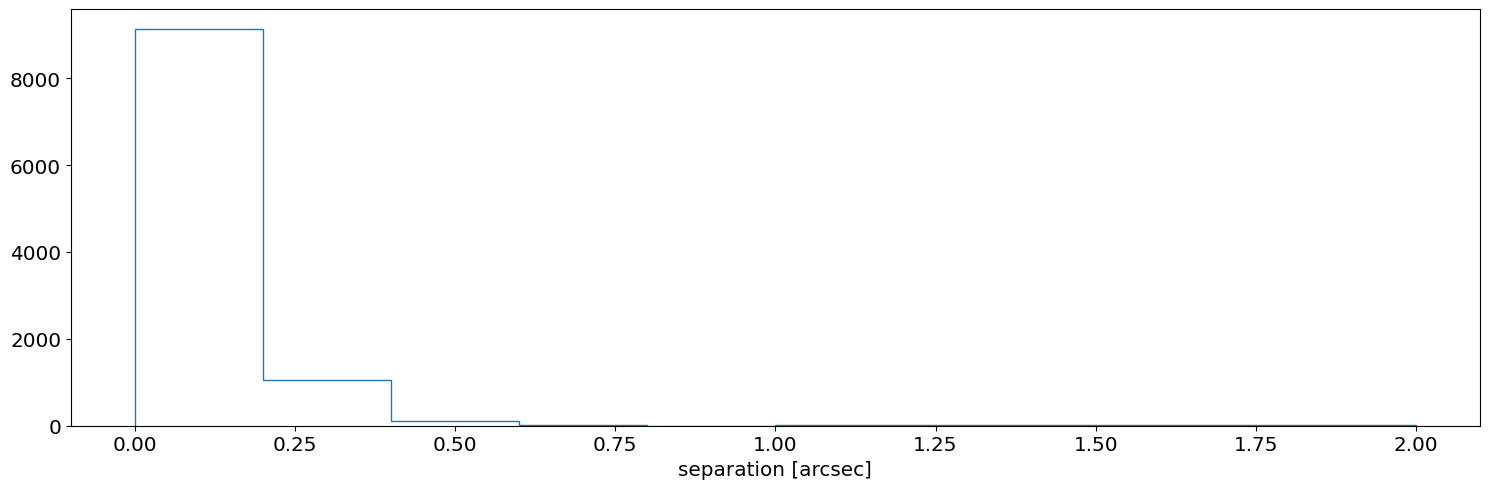

In [13]:
lsstSkyCoord = SkyCoord(ra=lsst_ra.values*u.degree, dec=lsst_dec.values*u.degree, frame = 'icrs')
euclidSkyCoord = SkyCoord(ra=euclid_ra*u.degree, dec=euclid_dec*u.degree, frame = 'icrs')
index1, d2d1, d3d1 = lsstSkyCoord.match_to_catalog_sky(euclidSkyCoord)
#index = match index, d2d = distance apart on sky, d3d = 3D distance apart
matches1 = euclid_field[index1]
print(len(matches1))
plt.hist(d2d1.arcsec, histtype='step', range=(0,2))
plt.xlabel('separation [arcsec]')
plt.tight_layout()
plt.show()


##ok this has a whole bunch more than an arcsec apart, so probably don't wanna use this
#index2, d2d2, d3d2 = euclidSkyCoord.match_to_catalog_sky(comcamSkyCoord)
#index = match index, d2d = distance apart on sky, d3d = 3D distance apart
#matches2 = comcam_field.to_numpy()[index2]
#print(len(matches2))
#plt.hist(d2d2.arcsec, histtype='step', range=(0,2))
#plt.xlabel('separation [arcsec]')
#plt.tight_layout()
#plt.show()

In [14]:
lsst_df = pd.DataFrame(matches_lsst, columns = lsst_field.columns)
euclid_df = pd.DataFrame(matches_euclid)
merged_df = lsst_df.join(euclid_df)
print(len(lsst_df), len(euclid_df))
#merged_df.sort_values('POINT_LIKE_PROB')['POINT_LIKE_PROB']
#ok then if you notice they're different it's bc some sources don't have a i_sizeextendedness, same w point_like_prob

10337 10337


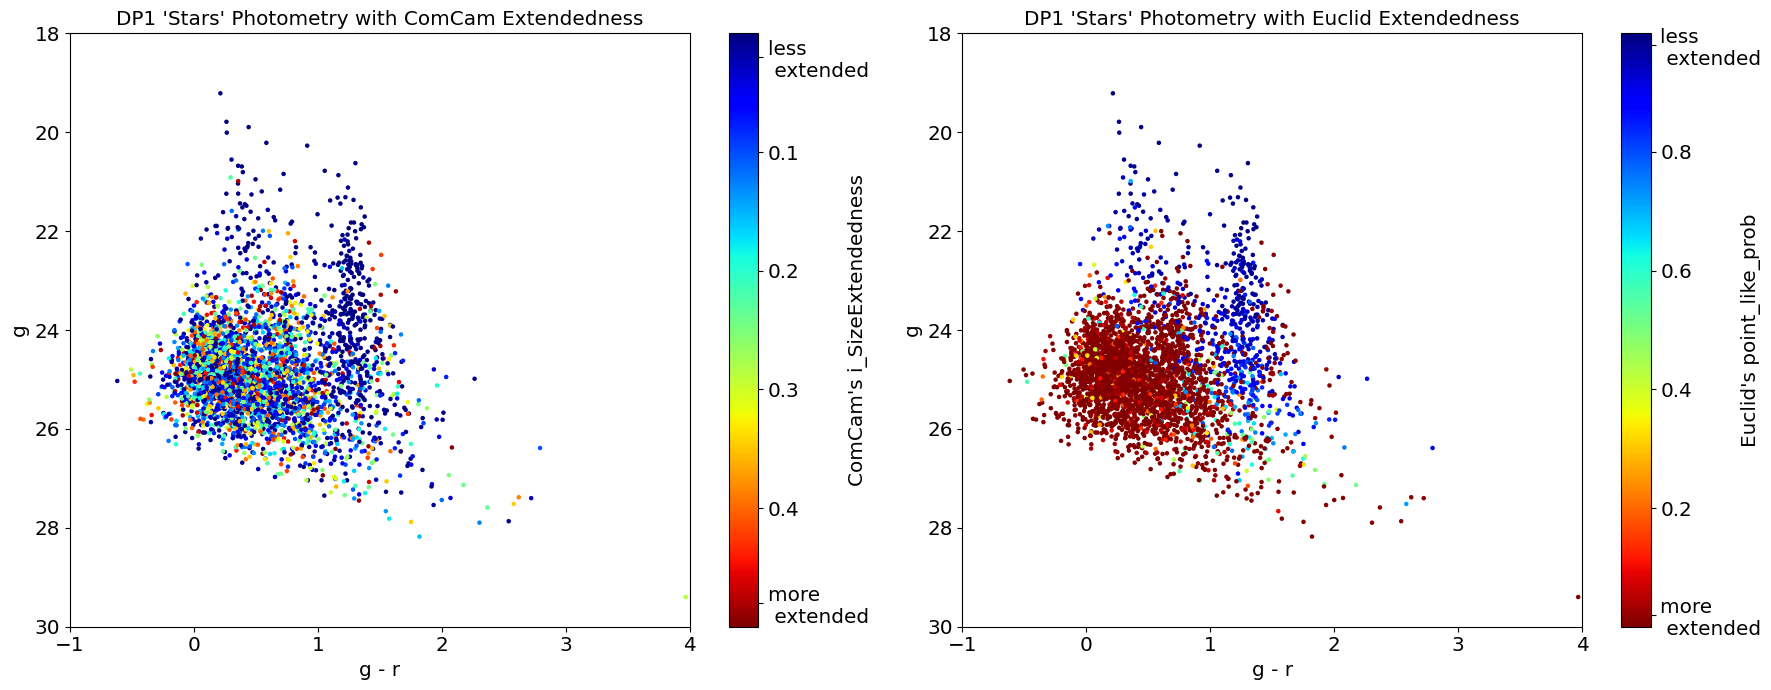

In [15]:
#PLOT 1: color-magnitude
fig, ax = plt.subplots(1,2, figsize=(18,7))

band = 'i'
label = f"{band}_SizeExtendedness"
lsst_extendedness = merged_df[label]
star_df = merged_df[lsst_extendedness<0.5] #nominal star-gal sep

lsst_g_mag = flux2mag(star_df["g_psfFlux"].values)
lsst_r_mag = flux2mag(star_df["r_psfFlux"].values)


_ = ax[0].scatter(lsst_g_mag - lsst_r_mag,
            lsst_g_mag,
            c=star_df[label],
            s=5, cmap="jet")
cbar1 = plt.colorbar(_, ticks=[0.48, 0.4, 0.3, 0.2, 0.1, 0.02])
cbar1.ax.invert_yaxis()
cbar1.ax.set_yticklabels(['more \n extended', '0.4', '0.3', '0.2', '0.1', 'less \n extended']) 
cbar1.set_label(f"ComCam's {band}_SizeExtendedness", labelpad = -15)
ax[0].set(xlabel='g - r', ylabel='g', xlim = (-1, 4), 
          ylim = (30, 18), title='DP1 \'Stars\' Photometry with ComCam Extendedness')
_ = ax[1].scatter(lsst_g_mag - lsst_r_mag,
            lsst_g_mag,
            c=star_df['POINT_LIKE_PROB'],
            s=5, cmap="jet_r")
cbar2 = plt.colorbar(_, ticks=[0.02, 0.2, 0.4, 0.6, 0.8, 0.98])
ax[1].set(xlabel='g - r', ylabel='g', xlim = (-1, 4),
          ylim = (30, 18), title='DP1 \'Stars\' Photometry with Euclid Extendedness')
cbar2.ax.set_yticklabels(['more \n extended', '0.2', '0.4', '0.6', '0.8', 'less \n extended'])
cbar2.set_label(f"Euclid's point_like_prob", labelpad = -15)
plt.tight_layout()
plt.savefig(my_path + f"/euclidcomparison_colormag.png")

/tmp/ipykernel_3119/1497302383.py:4: RuntimeWarning: invalid value encountered in log10
  return -2.5*np.log10(flux) + zeropoint


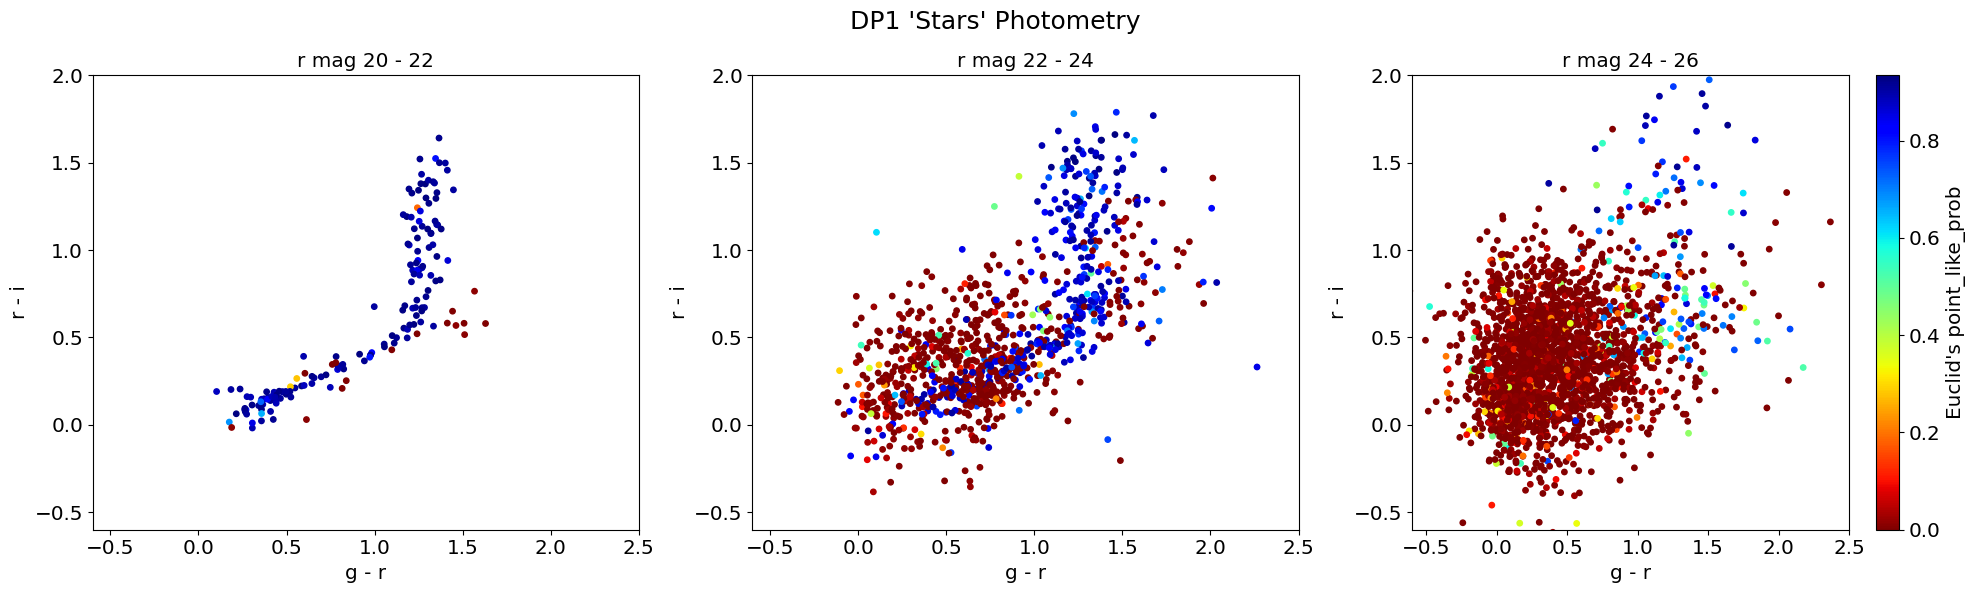

In [36]:
#PLOT 2: color-color
fig, ax = plt.subplots(1,3, figsize=(20,6))
plt.suptitle('DP1 \'Stars\' Photometry', fontsize = 18)
#do I use psf or cmodel flux
band = 'i'
label = f"{band}_SizeExtendedness"
cbarlabel = f"ComCam's {band}_SizeExtendedness"
lsst_extendedness = merged_df[label]
star_df = merged_df[lsst_extendedness<0.5] #nominal star-gal sep
plt_df = star_df
label = "POINT_LIKE_PROB"
cbarlabel = f"Euclid's point_like_prob"

lsst_g_mag = flux2mag(plt_df["g_psfFlux"].values)
lsst_r_mag = flux2mag(plt_df["r_psfFlux"].values)
lsst_i_mag = flux2mag(plt_df["i_psfFlux"].values)

bright = {"r mag" : [], "g mag" : [], "i mag" : [], "ext" : []}
middle = {"r mag" : [], "g mag" : [], "i mag" : [], "ext" : []}
dim = {"r mag" : [], "g mag" : [], "i mag" : [], "ext" : []}

for i in range(len(lsst_r_mag)):
    r_i = lsst_r_mag[i]
    if (r_i > 18) and (r_i < 22):
        bright["r mag"].append(r_i)
        bright["g mag"].append(lsst_g_mag[i])
        bright["i mag"].append(lsst_i_mag[i])
        bright["ext"].append(plt_df[label].to_list()[i])
    elif (r_i > 22) and (r_i < 24):
        middle["r mag"].append(r_i)
        middle["g mag"].append(lsst_g_mag[i])
        middle["i mag"].append(lsst_i_mag[i])
        middle["ext"].append(plt_df[label].to_list()[i])
    else:
        dim["r mag"].append(r_i)
        dim["g mag"].append(lsst_g_mag[i])
        dim["i mag"].append(lsst_i_mag[i])
        dim["ext"].append(plt_df[label].to_list()[i])
for dic in [bright, middle, dim]:
    for key in dic.keys():
        dic[key] = np.array(dic[key])

_ = ax[0].scatter(bright["g mag"] - bright["r mag"], bright["r mag"] - bright["i mag"],
            c=bright["ext"],
            s=15, cmap="jet_r")
#plt.colorbar(_,label=cbarlabel)
_ = ax[1].scatter(middle["g mag"] - middle["r mag"], middle["r mag"] - middle["i mag"],
            c=middle["ext"],
            s=15, cmap="jet_r")
#plt.colorbar(_,label=cbarlabel)
_ = ax[2].scatter(dim["g mag"] - dim["r mag"], dim["r mag"] - dim["i mag"],
            c=dim["ext"],
            s=15, cmap="jet_r")
plt.colorbar(_,label=cbarlabel)
ax[0].set(ylabel='r - i', ylim = (-0.6,2),
          xlabel='g - r', xlim = (-0.6,2.5),
          title='r mag 20 - 22')
ax[1].set(ylabel='r - i', ylim = (-0.6,2),
          xlabel='g - r', xlim = (-0.6,2.5),
          title='r mag 22 - 24')
ax[2].set(ylabel='r - i', ylim = (-0.6,2),
          xlabel='g - r', xlim = (-0.6,2.5),
          title='r mag 24 - 26')
plt.tight_layout()
plt.savefig(my_path + f"/euclidcomparison_colorcolor3.png")

In [20]:
#merged_df.columns.to_list()

/tmp/ipykernel_3119/1497302383.py:4: RuntimeWarning: invalid value encountered in log10
  return -2.5*np.log10(flux) + zeropoint


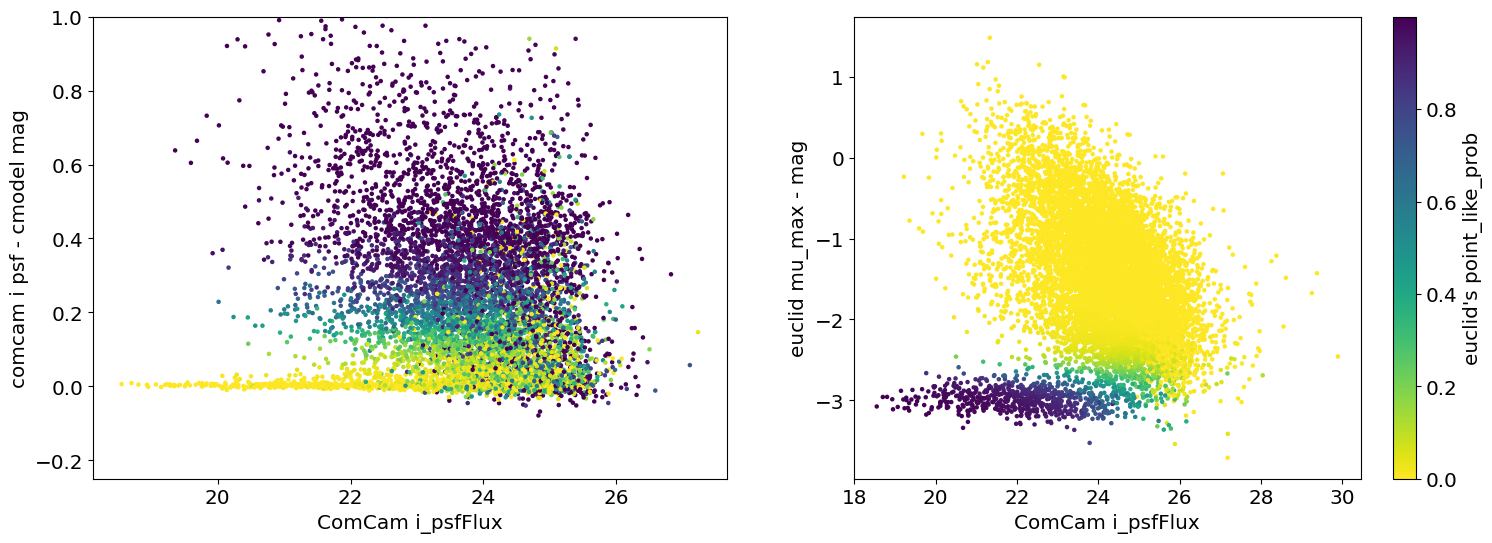

In [39]:
#PLOT 3
fig, ax = plt.subplots(1,2, figsize=(18,6))

plt_df = merged_df #[merged_df['POINT_LIKE_PROB']>0.2]
lsst_i_mag = flux2mag(plt_df["i_psfFlux"].values)
lsst_i_mag_cmodel = flux2mag(plt_df["i_cModelFlux"].values)

_=ax[0].scatter(lsst_i_mag,
            lsst_i_mag - lsst_i_mag_cmodel,
            c=plt_df["i_SizeExtendedness"],
            s=5, cmap="viridis_r")
#plt.colorbar(_,label="Euclid's point_like_prob".lower())
ax[0].set(ylim = (-0.25,1.0), xlabel='ComCam i_psfFlux', ylabel='ComCam i psf - cmodel mag'.lower())
#_=ax[1].scatter(lsst_i_mag,
#            plt_df['FLUX_VIS_PSF'] - plt_df['FLUX_VIS_SERSIC'],
#            c=plt_df["POINT_LIKE_PROB"],
#            s=5, cmap="viridis_r")
#plt.colorbar(_,label="Euclid's point_like_prob".lower())
#ax[1].set(ylim = (-10,1), xlabel='ComCam i_psfFlux', ylabel='Euclid vis psf - sersic fit mag'.lower())
_=ax[1].scatter(lsst_i_mag,
            plt_df['MUMAX_MINUS_MAG'],
            c=plt_df["POINT_LIKE_PROB"],
            s=5, cmap="viridis_r")
plt.colorbar(_,label="Euclid's point_like_prob".lower())
ax[1].set(xlabel='ComCam i_psfFlux', ylabel='Euclid mu_max - mag'.lower())
plt.savefig(my_path + '/star-gal-sep.png')

In [ ]:
#from slack
#tract is a large section of the sky, made up of 10x10 patches
tract_dict={453: '47 Tuc', 
            454: '47 Tuc',
           4849: 'ECDFS', 
           5063: 'ECDFS',
           4848: 'ECDFS', 
           2394: 'EDFS', 
           2234: 'EDFS',
           4016: 'Fornax', 
           4017: 'Fornax', 
           4218: 'Fornax', 
           4217: 'Fornax', 
           5525: 'Rubin_SV_095-25', 
           5526: 'Rubin_SV_095-25', 
           7611: 'Seagull', 
           7610: 'Seagull', 
           7850: 'Seagull',
           10463: 'Rubin_SV_38_7', 
           10464: 'Rubin_SV_38_7', 
           10704: 'Rubin_SV_38_7'
           }

Center of EDFS from Euclid site: '04:04:57.84', '-48:25:22.8'  
- The polygon is defined by vertices = [[63.25, -45.67], [65.35, -46.10], [66.40, -47.25], [65.99, -48.72],
                                        [59.25, -51.19], [56.95, -50.82], [55.90, -49.40], [56.80, -47.99]])  
  
Center of EDFS from LSST site: '59.10 -48.73'  (note: these are different !)

Euclid calls Chandra Deep Field South "Fornax"  
Comcam right now has 2 deep fields, LSST will get it in the sv surveys

In [ ]:
##Learning hp package

NPIX = hp.nside2npix(NSIDE)

center_c = SkyCoord('04:04:57.84', '-48:25:22.8', unit=(u.hourangle, u.deg))
c_RA, c_DEC = center_c.ra.deg, center_c.dec.deg
center_pix = hp.ang2pix(NSIDE, c_RA, c_DEC, lonlat=True, nest=True)

#print(c_RA, c_DEC)

#print(f"NSIDE=64, Nest, HEALPix: {center_pix}")
print('center', center_pix)
vertices = np.array([[63.25, -45.67], [65.35, -46.10], [66.40, -47.25], 
       [65.99, -48.72], [59.25, -51.19], [56.95, -50.82], 
       [55.90, -49.40], [56.80, -47.99]])
#ang2pix(theta, phi)
vert_pix = hp.ang2pix(NSIDE, vertices[:,0], vertices[:,1], lonlat=True, nest=True)
print('vertices', vert_pix)


#ang2vec(lon, lat)
new_vert = hp.ang2vec(vertices[:,0], vertices[:,1], lonlat=True)
edfs = hp.query_polygon(NSIDE, new_vert, inclusive=True, nest=True)
print('field from query', edfs)


new_cen = hp.ang2vec(c_RA, c_DEC, lonlat=True)
circ = hp.query_disc(NSIDE, new_cen, np.radians(1), nest=True)
#print(circ)
m = np.arange(NPIX)
m[edfs] = m.max()
m[circ] = m.min()
hp.mollview(m, nest=True)

In [ ]:
"""
outside query
    config['data_dir'] = 'sdf/data/rubin/user/kexcel/software'     # dustmaps
    dustmaps.sfd.fetch()
    sfd = SFDQuery()
in query
    #Define E(B-V) at that position using SFD reddening maps
    R_g = 3.64
    R_r = 2.70
    R_i = 2.06

    E_BV = sfd(coord)

    A_g = R_g *E_BV
    A_r = R_r *E_BV
    A_i = R_i *E_BV
"""
#^ dustmap stuff, maybe add back in eventually
"""
# Quality selection and star--galaxy separation adapted from
    # https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/object_pandas_stellar_locus.ipynb
    snr_threshold = 5
    mag_err_threshold = 1/snr_threshold
    mag_threshold =26 
"""
#^ doing this in a different way i think...
"""
can have this syntax: 
        #scisql_nanojanskyToAbMag(g_cModelFlux) AS mag_g,
        #scisql_nanojanskyToAbMag(r_cModelFlux) AS mag_r,
        #scisql_nanojanskyToAbMagSigma(g_cModelFlux, g_cModelFluxErr) AS magerr_g, 
        #scisql_nanojanskyToAbMagSigma(r_cModelFlux, r_cModelFluxErr) AS magerr_r,
        #scisql_nanojanskyToAbMag(g_cModelFlux) - {A_g} AS mag_corrected_g,     <-- dustmap stuff
        #scisql_nanojanskyToAbMag(r_cModelFlux) - {A_r} AS mag_corrected_r,
"""
#^but since I don't understand it, I'm leaving that out of the query

In [ ]:
## OLD CODE

'''
Rn I'm thinking the best way is to go pixel by pixel and cut the euclid data that doesn't align with the bounds of the comcam data,
but how to do that??
'''

'''
#gathering the pixels of all the comcam sources, making that a column in the dataframe
comcam_ra1 = raw_comcam1['coord_ra'] 
comcam_dec1 = raw_comcam1['coord_dec']
comcam_pix1 = hp.ang2pix(NSIDE, comcam_ra1, comcam_dec1, lonlat=True, nest=True)
raw_comcam1['hp pix'] = comcam_pix1

comcam_ra2 = raw_comcam2['coord_ra']
comcam_dec2 = raw_comcam2['coord_dec']
comcam_pix2 = hp.ang2pix(NSIDE, comcam_ra2, comcam_dec2, lonlat=True, nest=True)
raw_comcam2['hp pix'] = comcam_pix2

comcam1 = raw_comcam1.to_pandas()
comcam2 = raw_comcam2.to_pandas()
comcam_edfs_total = pd.concat([comcam1[comcam1['hp pix'].isin(list(edfs))], comcam2[comcam2['hp pix'].isin(list(edfs))]])

#combining the two tracts corresponding to comcam's edfs (this is *total*)
print(len(comcam_edfs_total))
type(comcam_edfs_total)
'''

'''
Look at tutorial DP02_03a_Image_Display_and_Manipulation when wanting to do images
Make a cutout rather than whole thing
'''